# 1. Creating patches, embeddings and positional encodings

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (23/01/2025)

**Requirements:**
- Python 3 (tested on v3.13.1)
- Matplotlib (tested on v3.10)
- Numpy (tested on v2.2.1)
- Seaborn (tested on v0.13.2)
- Torch (tested on v2.7.0+cu124)

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Dataset preparation

For this task, we will use CIFAR-10. We can prepare the dataloader and dataset objects by simply loading them from the PyTorch library.

In [2]:
# 1. Load and preprocess the image dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = CIFAR10(root = "./data", train = True, download = True, transform = transform)

### Defining a PatchEmbedding class to produce patches and linear embeddings for patches

In order to split our images into patches, we will first write a class for the patch, shown below.
It objective is twofold, it should:
- Receive an image coming from CIFAR-10, with size 32 by 32,
- Split the image into patches of size 8 by 8,
- Use a Conv2d, followed by a flatten operation, to produce a 1D vector with 64 elements, which consists of the embedding for this patch.

In [3]:
# Define Patch Embedding function
class PatchEmbedding(nn.Module):
    def __init__(self, img_size = 32, patch_size = 8, \
                 in_channels = 3, embed_dim = 64):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Conv2d(in_channels, embed_dim, \
                                    kernel_size = patch_size, \
                                    stride = patch_size)

    def forward(self, x):
        # Convert image to patches
        x = self.projection(x) 
        # Flatten and rearrange
        patches = x.flatten(2).transpose(1, 2) 
        return patches

Below, we simply confirm that we have produced 16 embedding vectors, for all 16 patches and each vector is of dimension 64.

In [4]:
# Select the first image of the dataset
# We use unsqueeze, to add the batch dimension, 
# our image is then a tensor of size (1, 3, 32, 32)
image, label = dataset[0] 
image = image.unsqueeze(0)  

# Create Patch Embedding module
patch_embedding = PatchEmbedding(img_size = 32, patch_size = 8, \
                                 in_channels = 3, embed_dim = 64)

# Apply the patch embedding
patches = patch_embedding(image)
# Patches are tensors of size (batch_size = 1, num_patches = 16, embed_dim = 64)
print(f"Patches Shape: {patches.shape}")

Patches Shape: torch.Size([1, 16, 64])


Using the helper function below, we can confirm that the image of size 32 by 32 has indeed been split into 16 patches of size 8 by 8.

In [5]:
def visualize_patches(img, patch_size):
    # Visualize the image before and after patch division
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    # Original Image
    img_np = img.squeeze().permute(1, 2, 0).numpy()
    ax[0].imshow(img_np)
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    # Image Divided into Patches
    ax[1].imshow(img_np)
    for i in range(0, img_np.shape[1], patch_size):
        ax[1].axvline(i, color = 'r', linestyle = '--')
        ax[1].axhline(i, color = 'r', linestyle = '--')
    ax[1].set_title("Image Divided into Patches")
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()

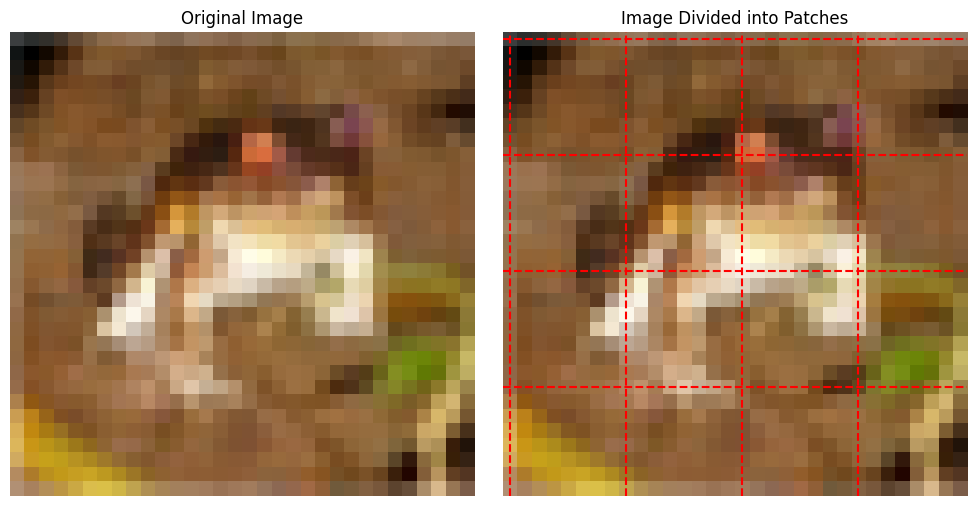

In [6]:
# Visualize the original image and the divided patches
visualize_patches(image[0], patch_size = 8)

### Positional Encoding

We will start by implementing the sinusoidal positional encoding shown in the slides.

In [7]:
# Define Sinusoidal Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.position_encoding = self.create_position_encoding()

    def create_position_encoding(self):
        # Create a matrix of shape (num_patches, embed_dim)
        # Patch indexes
        pos = np.arange(self.num_patches).reshape(-1, 1)
        # Embedding indexes
        dim = np.arange(self.embed_dim).reshape(1, -1)
        angle_rates = 1/np.power(10000, (2*(dim//2))/np.float32(self.embed_dim))
        position_encoding = pos*angle_rates  # Positional information
        # Apply sine to even indices and cosine to odd indices
        position_encoding[:, 0::2] = np.sin(position_encoding[:, 0::2])
        position_encoding[:, 1::2] = np.cos(position_encoding[:, 1::2])
        return torch.tensor(position_encoding, dtype=torch.float32)

    def forward(self, x):
        return x + self.position_encoding

We can test our positional encodings below.

In [16]:
# Patches Parameters
num_patches = 16
embed_dim = 64

# Visualizing Positional Encodings
pos_encoding = PositionalEncoding(num_patches = num_patches, embed_dim = embed_dim)
positions = pos_encoding.position_encoding

# Demonstration of Adding Positional Encoding to Patch Embeddings
# Random example patch embeddings
patch_embeddings = torch.rand(num_patches, embed_dim)
encoded_patches = pos_encoding(patch_embeddings)
print("Shape of patch embeddings before positional encoding:", patch_embeddings.shape)
print("Shape of patch embeddings after positional encoding:", encoded_patches.shape)

Shape of patch embeddings before positional encoding: torch.Size([16, 64])
Shape of patch embeddings after positional encoding: torch.Size([16, 64])


Eventually, using cosine similarity, we can again compute the similarity between two positional encoding vectors, to confirm that vectors k and k+1 are close to each other.

In [10]:
def cosine_similarity(vec1, vec2):
    # Helper function to calculate cosine similarity
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product/(norm1*norm2)

# Calculate cosine similarity between specified patches
similarity_5_6 = cosine_similarity(positions[5], positions[6])
similarity_5_7 = cosine_similarity(positions[5], positions[7])
similarity_5_8 = cosine_similarity(positions[5], positions[8])
similarity_6_7 = cosine_similarity(positions[6], positions[7])
similarity_7_8 = cosine_similarity(positions[7], positions[8])

print(f"Cosine Similarity between patch 5 and 6: {similarity_5_6:.4f}")
print(f"Cosine Similarity between patch 5 and 7: {similarity_5_7:.4f}")
print(f"Cosine Similarity between patch 5 and 8: {similarity_5_8:.4f}")
print(f"Cosine Similarity between patch 6 and 7: {similarity_6_7:.4f}")
print(f"Cosine Similarity between patch 7 and 8: {similarity_7_8:.4f}")

Cosine Similarity between patch 5 and 6: 0.9662
Cosine Similarity between patch 5 and 7: 0.8845
Cosine Similarity between patch 5 and 8: 0.7996
Cosine Similarity between patch 6 and 7: 0.9662
Cosine Similarity between patch 7 and 8: 0.9662


C:\Users\matth\AppData\Local\Temp\ipykernel_11680\1770728128.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  dot_product = np.dot(vec1, vec2)


The matplotlib graph below shows a very typical visualization for positional encodings using sinusoidal formulas.

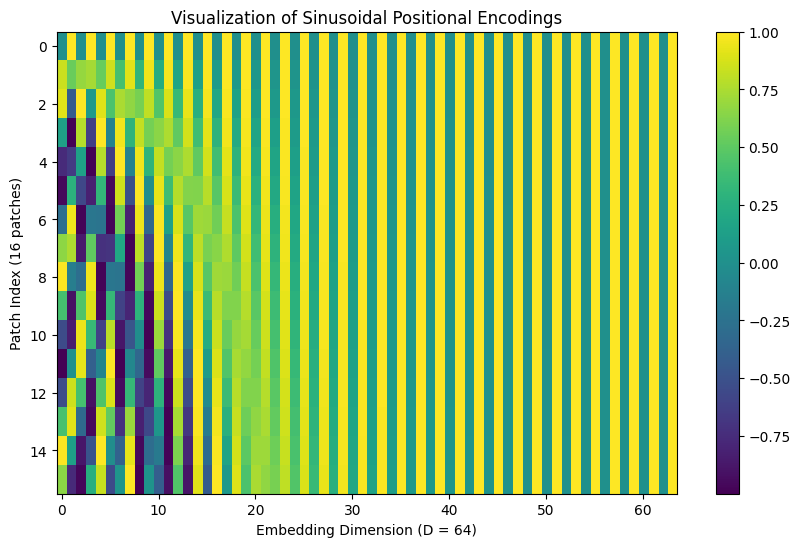

In [11]:
plt.figure(figsize = (10, 6))
plt.imshow(positions, cmap = "viridis", aspect = "auto")
plt.colorbar()
plt.title("Visualization of Sinusoidal Positional Encodings")
plt.xlabel("Embedding Dimension (D = 64)")
plt.ylabel("Patch Index (16 patches)")
plt.show()

### From 1D to 2D positional encodings

As explained in slides, we can use the sinusoidal positional encoding intuition to make 2D positional encodings.

In [12]:
def generate_2d_positional_encoding(grid_size, embed_dim):
    # Generate 2D sinusoidal positional encodings for a patch grid.
    num_rows, num_cols = grid_size
    # Create row and column positional encodings
    row_pos = np.arange(num_rows).reshape(-1, 1)  # Row indices
    col_pos = np.arange(num_cols).reshape(-1, 1)  # Column indices
    d = np.arange(embed_dim // 2).reshape(1, -1)  # Embedding dimensions
    # Calculate row and column positional encodings using sine and cosine
    angle_rates = 1 / np.power(10000, (2 * d) / embed_dim)
    row_encoding = np.concatenate([np.sin(row_pos * angle_rates), np.cos(row_pos * angle_rates)], axis=-1)
    col_encoding = np.concatenate([np.sin(col_pos * angle_rates), np.cos(col_pos * angle_rates)], axis=-1)
    # Combine row and column encodings
    row_encoding = np.tile(row_encoding[:, np.newaxis, :], (1, num_cols, 1))
    col_encoding = np.tile(col_encoding[np.newaxis, :, :], (num_rows, 1, 1))
    pos_encoding = row_encoding + col_encoding  # Add row and column encodings
    return pos_encoding.reshape(-1, embed_dim)  # Flatten to (num_patches, embed_dim)

This is, again, a very typical visualization for a 2D sinusoidal positional encoding 

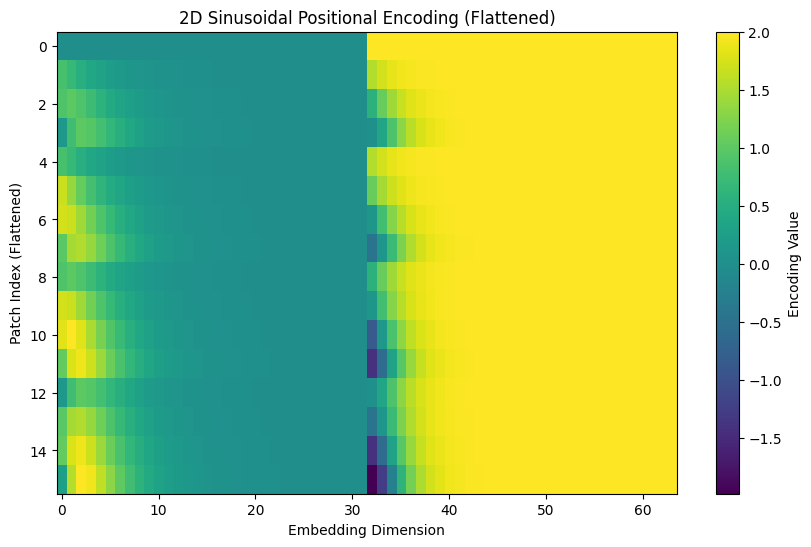

In [13]:
# Example Usage
# 4x4 grid (16 patches)
grid_size = (4, 4)
# Embedding dimension is still 64
embed_dim = 64
positional_encodings = generate_2d_positional_encoding(grid_size, embed_dim)

# Visualize Positional Encoding
plt.figure(figsize=(10, 6))
plt.imshow(positional_encodings, cmap="viridis", aspect="auto")
plt.colorbar(label="Encoding Value")
plt.title("2D Sinusoidal Positional Encoding (Flattened)")
plt.xlabel("Embedding Dimension")
plt.ylabel("Patch Index (Flattened)")
plt.show()

We can confirm the 2D similarity this time, by plotting the following heatmap, which shows the cosine distance between the positional encodings for any two pairs of patches.

In [14]:
def calculate_pairwise_cosine_distance(encodings):
    # Helper function to calculate cosine distances between
    # positional encodings for all the possible pairs of patches
    num_patches = encodings.shape[0]
    cosine_distances = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            dot_product = np.dot(encodings[i], encodings[j])
            norm_i = np.linalg.norm(encodings[i])
            norm_j = np.linalg.norm(encodings[j])
            cosine_similarity = dot_product / (norm_i * norm_j)
            cosine_distances[i, j] = 1 - cosine_similarity  # Convert to cosine distance
    return cosine_distances

The heatmap below shows that patches 0 and 1 are similar but so are patches 0 and 4, as is expected from a 2D positional encoding.

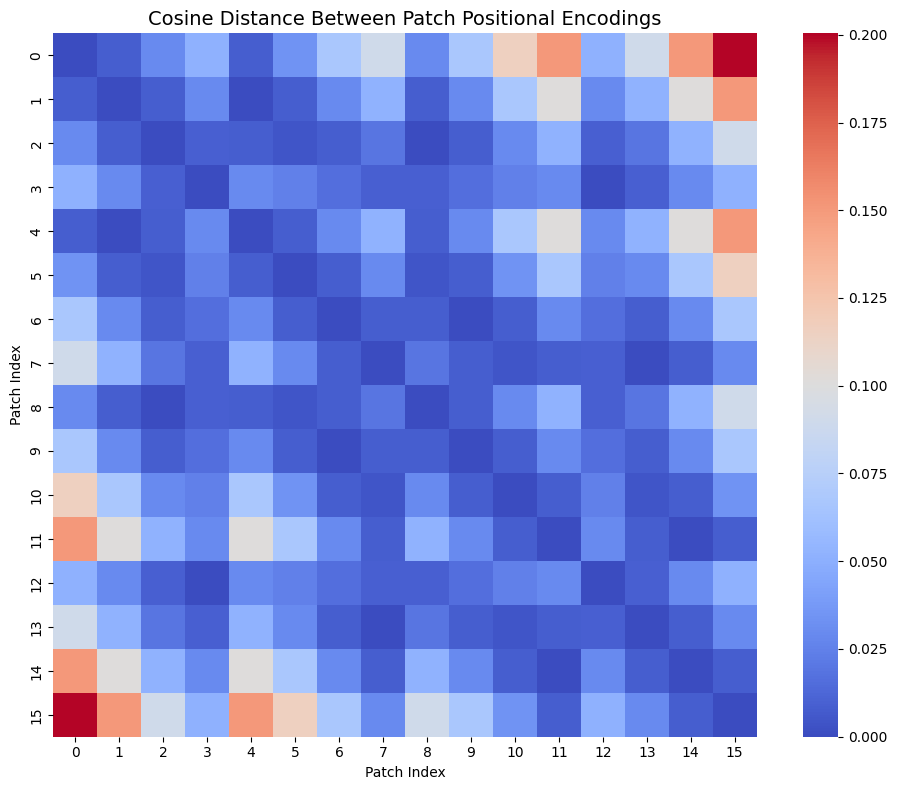

In [15]:
# Generate pairwise cosine distances
cosine_distances = calculate_pairwise_cosine_distance(positional_encodings)

# Visualize the cosine distances as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_distances, cmap = "coolwarm", annot = False, square = True, cbar = True,
            xticklabels = np.arange(positional_encodings.shape[0]),
            yticklabels = np.arange(positional_encodings.shape[0]))
plt.title("Cosine Distance Between Patch Positional Encodings", fontsize=14)
plt.xlabel("Patch Index")
plt.ylabel("Patch Index")
plt.tight_layout()
plt.show()